In [1]:
import csv
import os
import pymc as pm
from pymc import do, observe
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import itertools as it
import country_converter as cc
import math
from sklearn.linear_model import LinearRegression
import graphviz

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset.csv")
print(len(data))

9093


# remove missing data

In [13]:
# remove all data or year for countries where one of the 3 variables is entirely missing

country_temp_data = {}
country_precip_data = {}

for row in data.iterrows():
    country = row[1].iso
    if country not in country_temp_data:
        country_temp_data[country] = []
    if country not in country_precip_data:
        country_precip_data[country] = []
    country_temp_data[country].append(row[1].UDel_temp_popweight)
    country_precip_data[country].append(row[1].UDel_precip_popweight)

countries_missing_temp = [country for country in country_temp_data if all(np.isnan(country_temp_data[country]))]
countries_missing_precip = [country for country in country_precip_data if all(np.isnan(country_precip_data[country]))]

countries_to_remove = set(countries_missing_temp + countries_missing_precip)

print(countries_to_remove)

indices_to_drop = []
for index, row in enumerate(data.itertuples()):
    if row.iso in countries_to_remove:
        indices_to_drop.append(index)

data_len_before = len(data)
data = data.drop(indices_to_drop)
data = data.reset_index()
print(f"Removed {data_len_before - len(data)} rows for completely missing country data.")

{'SGP', 'SMR', 'MHL', 'MAC', 'KNA', 'BMU', 'LCA', 'MDV', 'TON', 'BHR', 'GRD', 'SYC', 'MCO', 'PLW', 'ATG', 'HKG', 'BRB', 'FSM', 'ADO', 'ABW', 'MNE', 'TMP', 'TUV', 'MLT', 'KIR', 'LIE', 'CHI', 'WBG', 'KSV', 'IMY', 'COD', 'DMA', 'TWN', 'ROU'}
Removed 1262 rows for completely missing country data.


In [11]:
# optionally remove all rows with any missing value

indices_to_drop = []
no_nan_cols = ["UDel_temp_popweight","UDel_precip_popweight","growthWDI"]
for index, row in enumerate(data.itertuples()):
    if any(np.isnan(getattr(row,col)) for col in no_nan_cols):
        indices_to_drop.append(index)
data_no_missing = data.drop(indices_to_drop)
data = data_no_missing
# data = data_no_missing.reset_index()

# data scaling

In [12]:
precip_scaler, gdp_scaler, temp_scaler = StandardScaler(), StandardScaler(), StandardScaler()
precip_scaled = precip_scaler.fit_transform(np.array(data.UDel_precip_popweight).reshape(-1,1)).flatten()
gdp_scaled = gdp_scaler.fit_transform(np.array(data.growthWDI).reshape(-1,1)).flatten()
temp_scaled = temp_scaler.fit_transform(np.array(data.UDel_temp_popweight).reshape(-1,1)).flatten()

# linear regression

In [8]:
from sklearn.linear_model import LinearRegression
y = np.array(data.growthWDI).reshape(-1,1)
x = np.transpose(np.array([data.UDel_temp_popweight,np.square(data.UDel_temp_popweight),data.UDel_precip_popweight,np.square(data.UDel_precip_popweight)]))
# x = np.transpose(np.array([data.UDel_temp_popweight,np.square(data.UDel_temp_popweight)]))
model = LinearRegression().fit(x,y)
print(model.coef_, model.intercept_)

[[ 8.38589795e-04 -4.50499041e-05  3.81664518e-06 -3.22334981e-10]] [0.01702781]


In [103]:
from sklearn.linear_model import LinearRegression
y = np.array(gdp_scaled).reshape(-1,1)
# x = np.transpose(np.array([temp_scaled,np.square(temp_scaled),precip_scaled,np.square(precip_scaled)]))
x = np.transpose(np.array([temp_scaled,np.square(temp_scaled)]))
model = LinearRegression().fit(x,y)
print(model.coef_, model.intercept_)

[[-0.09037139 -0.03925769]] [0.03925769]


In [106]:
print((model.coef_[0][0] * np.std(data.growthWDI) / np.std(data.UDel_temp_popweight)) - 2 * (model.coef_[0][1] * np.mean(data.UDel_temp_popweight) * np.std(data.growthWDI) / np.square(np.std(data.UDel_temp_popweight))))
print(model.coef_[0][1] * np.std(data.growthWDI) / np.square(np.std(data.UDel_temp_popweight)))
# print(.0953 * np.std(data.growthWDI) / np.std(data.UDel_precip_popweight))
# print(.1543 * np.std(data.growthWDI) / np.square(np.std(data.UDel_precip_popweight)))

0.0008977706911867145
-4.343603854139065e-05


# year and country fixed effect coefficient matrices

In [13]:
min_year = min(data.year)
data_len = len(data.year)
year_mult_mat = [np.zeros(data_len) for year in set(data.year)]
country_mult_mat = [np.zeros(data_len) for country in set(data.iso)]
country_index = -1
curr_country = ""
for row_index, row in enumerate(data.itertuples()):
    if row.iso != curr_country:
        country_index += 1
        curr_country = row.iso
    year_index = row.year - min_year
    country_mult_mat[country_index][row_index] = 1
    year_mult_mat[year_index][row_index] = 1
country_mult_mat[0] = [1 for i in range(len(data))]

In [14]:
# gradual year-by-year effects
grad_effects_data1 = np.transpose(np.array(data.loc[:, data.columns.str.startswith(('_yi'))]))#/1000
grad_effects_data2 = np.transpose(np.array(data.loc[:, data.columns.str.startswith(('_y2'))]))#/1000000
grad_effects_data = np.concatenate([grad_effects_data1, grad_effects_data2])

In [1]:
with pm.Model() as model:

    gdp_intercept = pm.Normal("gdp_intercept", 0,5)
    temp_gdp_coef = pm.Normal('temp_gdp_coef',0,1)
    temp_sq_gdp_coef = pm.Normal('temp_sq_gdp_coef',0,1)
    precip_gdp_coef = pm.Normal("precip_gdp_coef",0,1)
    precip_sq_gdp_coef = pm.Normal("precip_sq_gdp_coef",0,1)

    country_coefs = pt.expand_dims(pm.Normal("country_coefs", 0, 5, shape=(len(set(data.iso))-1)),axis=1)
    country_coefs = pm.math.concatenate([[[0]],country_coefs])
    country_fixed_effects = pt.sum((country_mult_mat*country_coefs),axis=0)

    year_coefs = pt.expand_dims(pm.Normal("year_coefs", 0, 5, shape=(len(set(data.year))-1)),axis=1)
    year_coefs = pm.math.concatenate([[[0]],year_coefs])
    year_fixed_effects = pm.Deterministic("year_fixed_effects",pt.sum(year_coefs*year_mult_mat,axis=0))

    gradual_effect_coefs = pt.expand_dims(pm.Normal("grad_effect_coefs", 0, 5, shape=(len(grad_effects_data))),axis=1)
    gradual_effects = pm.Deterministic("grad_effects",pt.sum(gradual_effect_coefs*grad_effects_data,axis=0))

    gdp_prior = pm.Deterministic(  
        "gdp_prior",
        gdp_intercept +
        (temp_gdp_coef * temp_scaled) +
        (temp_sq_gdp_coef * pt.sqr(temp_scaled)) +
        (precip_gdp_coef * precip_scaled) +
        (precip_sq_gdp_coef * pt.sqr(precip_scaled)) +
        country_fixed_effects +
        year_fixed_effects +
        gradual_effects
    )

    # standard error clustered by country
    country_std = pt.expand_dims(pm.HalfNormal("country_std", sigma=1, shape=(len(set(data.iso)),)),axis=1)
    gdp_std = pm.Deterministic("gdp_std", pt.sum(country_std * country_mult_mat,axis=0))
    # gdp_posterior = pm.Normal('gdp_posterior', mu=gdp_prior, sigma=gdp_std, observed=gdp_scaled)
    
    # prior = pm.sample_prior_predictive()
    # trace = pm.sample(target_accept=.99)
    # posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

NameError: name 'pm' is not defined

In [30]:
model = pd.read_pickle('../models/nature_reproduction/burke-reproduction-mcmc-fixed-effects-grad-effects-deterministic-observed-hierarchical-std-error-withheld.pkl')
trace = model["trace"]
prior = model["prior"]
posterior = model["posterior"]
precip_scaler = model["precip_scaler"]
gdp_scaler = model["gdp_scaler"]
temp_scaler = model["temp_scaler"]

In [4]:
az.summary(trace, var_names=["temp_gdp_coef","temp_sq_gdp_coef","precip_gdp_coef","precip_sq_gdp_coef","gdp_intercept"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
temp_gdp_coef,-0.634,0.220,-1.037,-0.232,0.014,0.010,251.0,528.0,1.01
temp_sq_gdp_coef,-0.454,0.090,-0.618,-0.292,0.004,0.003,540.0,1486.0,1.01
precip_gdp_coef,0.067,0.067,-0.060,0.188,0.002,0.001,1295.0,2137.0,1.00
precip_sq_gdp_coef,-0.037,0.023,-0.077,0.008,0.001,0.000,1722.0,2470.0,1.00
gdp_intercept,0.169,0.447,-0.707,0.957,0.095,0.068,22.0,133.0,1.15


/tmp/ipykernel_7585/3226979871.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


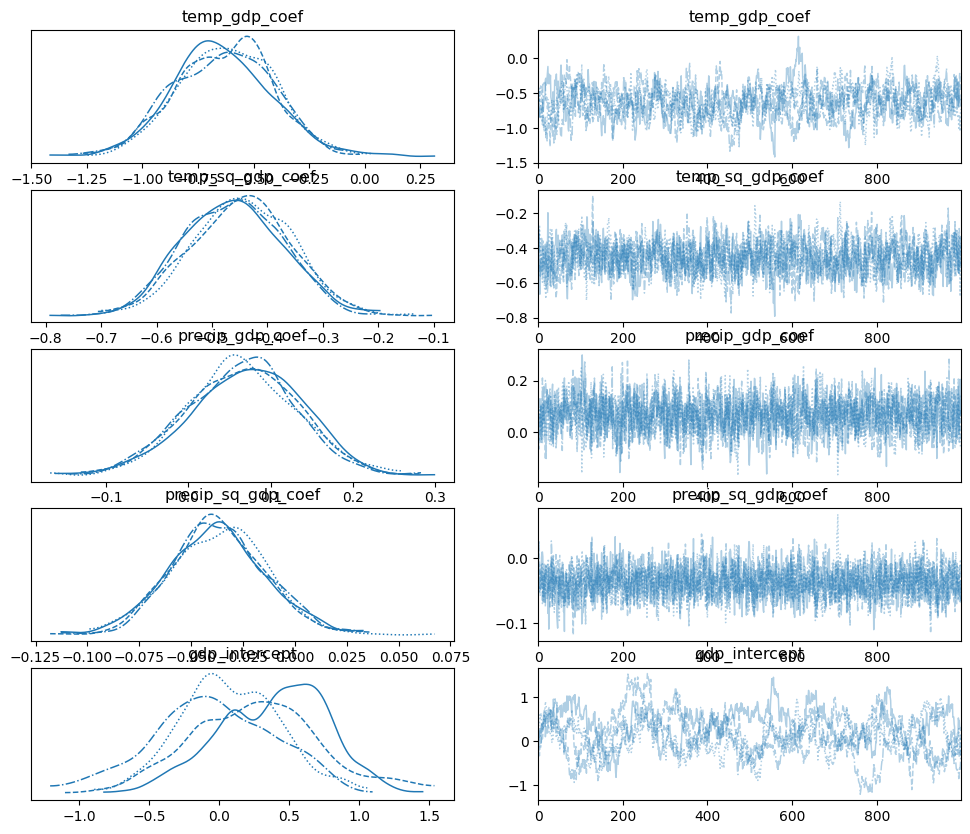

In [5]:
fig = az.plot_trace(trace, var_names=["temp_gdp_coef","temp_sq_gdp_coef","precip_gdp_coef","precip_sq_gdp_coef", "gdp_intercept"]).ravel()[0].figure
fig.show()

# Reproduce 13C threshold with probabilistic model

In [31]:
coef1 = trace.posterior.temp_gdp_coef.data.flatten()
coef2 = trace.posterior.temp_sq_gdp_coef.data.flatten()
coef1 = (coef1 * np.std(data.growthWDI) / np.std(data.UDel_temp_popweight)) - (2 * (coef2 * np.mean(data.UDel_temp_popweight * np.std(data.growthWDI)) / np.square(np.std(data.UDel_temp_popweight))))
coef2 = (coef2 * np.std(data.growthWDI) / np.square(np.std(data.UDel_temp_popweight)))
numerator = [val for val in coef1]
denominator = [-2*(val) for val in coef2]
res = np.array(numerator) / np.array(denominator)
print(np.mean(res), np.mean(res) - np.std(res) * 1.96, np.mean(res) + np.std(res) * 1.96)

13.902256938616382 10.674653332969346 17.12986054426342


In [73]:
# where does the original 13C estimate fall?
zscore = (13.06 - np.mean(res)) / np.std(res)
print(zscore)

-0.4044077726233159


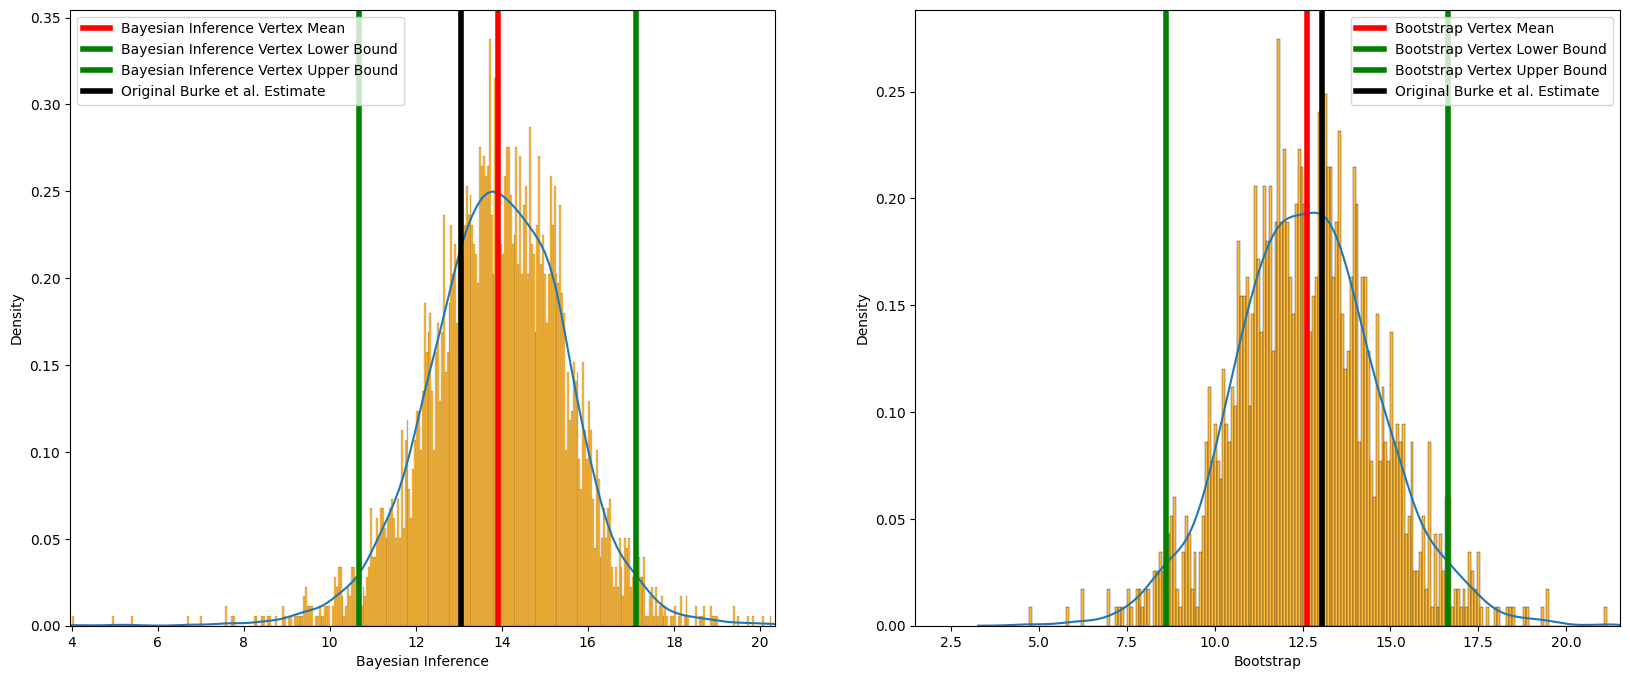

In [38]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

x = np.linspace(np.mean(res) - 3*np.std(res), np.mean(res) + 3*np.std(res), 100)
sns.histplot(res,bins=500,color="orange",stat="density", ax=ax1)
# plt.plot(x, stats.norm.pdf(x, np.mean(res), np.std(res)), color="blue")
sns.kdeplot(res, ax=ax1)
ax1.axvline(x = np.mean(res), color = 'r', lw = 4, label = 'Bayesian Inference Vertex Mean')
ax1.axvline(x = np.mean(res) - np.std(res) * 1.96, color = 'g', lw = 4, label = 'Bayesian Inference Vertex Lower Bound')
ax1.axvline(x = np.mean(res) + np.std(res) * 1.96, color = 'g', lw = 4, label = 'Bayesian Inference Vertex Upper Bound')
ax1.axvline(x = 13.06, color = 'k', lw = 4, label = 'Original Burke et al. Estimate')
ax1.set_xlim(min(x)-5, max(x)+1.5)
ax1.set_xlabel("Bayesian Inference")
ax1.legend()

x = np.linspace(np.mean(res2) - 3*np.std(res2), np.mean(res) + 3*np.std(res2), 100)
sns.histplot(res2,bins=200,color="orange",stat="density", ax=ax2)
# plt.plot(x, stats.norm.pdf(x, np.mean(res), np.std(res)), color="blue")
sns.kdeplot(res2, ax=ax2)
ax2.axvline(x = np.mean(res2), color = 'r', lw = 4, label = 'Bootstrap Vertex Mean')
ax2.axvline(x = np.mean(res2) - np.std(res2) * 1.96, color = 'g', lw = 4, label = 'Bootstrap Vertex Lower Bound')
ax2.axvline(x = np.mean(res2) + np.std(res2) * 1.96, color = 'g', lw = 4, label = 'Bootstrap Vertex Upper Bound')
ax2.axvline(x = 13.06, color = 'k', lw = 4, label = 'Original Burke et al. Estimate')
ax2.set_xlim(min(x)-5, max(x)+1.5)
ax2.set_xlabel("Bootstrap")
ax2.legend()

plt.show()
# plt.savefig("../figures/burke_reproduction_pdf.png")

# Standard Error Uncertainty Bounds

In [33]:
# Think this is wrong
# Look into Delta method

burke_temp_coef = .0127183
burke_temp2_coef = -.0004871
# standard errors
burke_temp_error = .0032479
burke_temp2_error = .0001029
# bootstrap errors
# burke_temp_error = .0033183
# burke_temp2_error = .0001056

# this is wrong you can't do it like this because you are assuming the low val of coef1 corresponds to the low val of coef2 but this is a false assumption
lower_bound = (burke_temp_coef - burke_temp_error ) / (-2 * (burke_temp2_coef - burke_temp2_error))
upper_bound = (burke_temp_coef + burke_temp_error ) / (-2 * (burke_temp2_coef + burke_temp2_error))
mean = burke_temp_coef / (-2 * burke_temp2_coef)
print(lower_bound)
print(upper_bound)
print(mean)

8.025762711864406
20.77850078084331
13.05512215150893


# Homespun Bootstrap Uncertainty Bounds

In [17]:
bootstrap_reps = pd.read_csv("../data/burke/data/input/bootstrap/burke_stata_bootstrap_replications.csv", header=1)
numerator = [val for val in bootstrap_reps["coef1"] if not np.isnan(val)]
denominator = [-2*(val) for val in bootstrap_reps["coef2"] if not np.isnan(val)]
res2 = np.array(numerator) / np.array(denominator)
print(np.mean(res2), np.mean(res2) - np.std(res2) * 1.96, np.mean(res2) + np.std(res2) * 1.96)

12.62084516826739 8.615730708694832 16.625959627839947


[Text(1, 0, 'Bayesian Inference'), Text(2, 0, 'Bootstrap')]

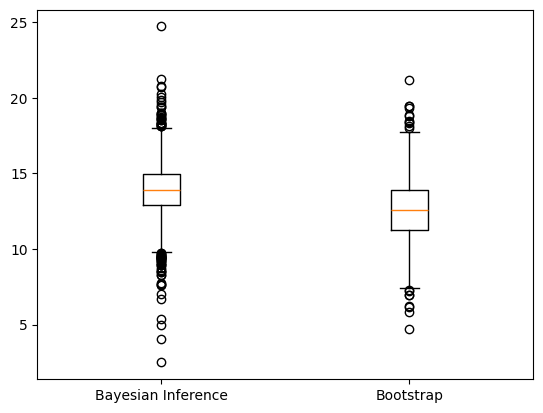

In [52]:
fig, ax = plt.subplots(1,1)
fig = plt.boxplot([res, res2])
ax.set_xticklabels(["Bayesian Inference", "Bootstrap"])

# Burke Bootstrap Uncertainty Bounds

In [5]:
bootstrap_reps = pd.read_csv("../data/burke/data/output/bootstrap/bootstrap_noLag.csv")
numerator = [val for val in bootstrap_reps["temp"] if not np.isnan(val)]
denominator = [-2*(val) for val in bootstrap_reps["temp2"] if not np.isnan(val)]
res = np.array(numerator) / np.array(denominator)
print(np.mean(res), np.mean(res) - np.std(res), np.mean(res) + np.std(res))

13.093787309224945 10.81081838113026 15.376756237319631


In [6]:
np.std(res)

2.2829689280946863